## Do Imports

In [1]:
%matplotlib inline


import numpy as np
import pandas as pd
import math
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import os
from fractions import Fraction 
import scipy.odr.odrpack as odrpack
import time
from bisect import bisect_left

## Define functions for dataSet computation

In [14]:
def avageAndStdDeviationOverSeconds(dataPoints, currentIndex, collumToAnalyze, averagingSeconds):
    '''
    Returns a tupel, with outTupel[0] the average and outTupel[1] the standard deviation.
    Calculates the average and standard deviation over a given time.
    Starting from the data point at currentIndex in dataPoints and going back the number of averagingSeconds.
    It is assumed, that dataPonts is a Pandas DataFrame, with timestamps as indexes
    and that it is sortet, so that the latest/newest entry is at the beginning of the DataFrame.
    '''
    timestamps = dataPoints.axes[0]
    data = dataPoints.values
    outTupel = [0, 0]
    secondsAgo = timestamps[currentIndex] - averagingSeconds
    if ( timestamps[len(timestamps)-1] > secondsAgo):
        secondsAgo = timestamps[len(timestamps)-1]
    # cut array
    lastIndex = 0
    for i in xrange(currentIndex, len(data)):
        if timestamps[i] <= secondsAgo :
            lastIndex = i
            break
    cutData = np.split(dataPoints, [currentIndex, lastIndex + 1])[1]
    data = cutData.values
    columNames = cutData.axes[1]
    # calculate average and variance
    avg = cutData[columNames[collumToAnalyze]].mean()
    outTupel[0] = avg
    std = cutData[columNames[collumToAnalyze]].std()
    outTupel[1] = std
    return outTupel

def nextMeasurementAndDistance(dataPoints, currentIndex, collumToAnalyze, numberOfMeasurementsToSkip=0):
    '''
    Returns a tuple with outTupel[0] the next measurement in time and outTupel[1]
    the distance of the next measurement to the timestamp at currentIndex, devided by averagingSeconds
    TODO: evaluate, how usefull it is to devide by averagingSeconds [edit: just removed it because it seemed useless]
    '''
    countNum = numberOfMeasurementsToSkip
    timestamps = dataPoints.axes[0]
    data = dataPoints.values
    outTupel = [0, 0]
    nextIndex = currentIndex + 1
    while True:
        if nextIndex >= len(timestamps):
            nextIndex = currentIndex
            break
        if math.isnan(data[nextIndex][collumToAnalyze]) == False:
            if countNum == 0:
                break
            else:
                countNum -= 1
        nextIndex = nextIndex + 1
    outTupel[0] = data[nextIndex][collumToAnalyze]
    outTupel[1] = (timestamps[currentIndex] - timestamps[nextIndex])
    return outTupel


def findIndexClostestThatIsNotNAN(startIndex, dataPoints, collumThatIsNotNAN):
    '''
    Returns an index for dataPoints, that is:
    a) in the collum "collumThatIsNotNAN" not nan.
    b) closest to startIndex (looking fowards and backwards at the same time in the array).
       This "proximity" does not take the timestamp into account, just the numerical
       distance from startIndex to the returned index.
    If no occurence is found it will raise an error, but this case should be ultra rare.
    ATENTION: This function may look into the "future" of the data set which may not be possible in the future.
    '''
    hitBeginningOfList = False
    hitEndOfList = False
    index1 = startIndex
    index2 = startIndex
    while (hitEndOfList==False) or (hitBeginningOfList==False):
        index1 += 1
        index2 -= 1
        if (hitEndOfList == True) or (index1 == len(dataPoints)):
            hitEndOfList = True
        else:
            currentDataPoint = dataPoints.values[index1]
            if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
                return index1
        if (hitBeginningOfList == True) or (index2 == -1):
            hitBeginningOfList = True
        else:
            currentDataPoint = dataPoints.values[index2]
            if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
                return index2
    raise StandardError("Could not find a closest occurence, does the data even contain values in that colum?")


def findDataPointClosestToTimestamp(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dataPoints.values[pos]
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return currentDataPoint
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, collumThatIsNotNAN)
        currentDataPoint = dataPoints.values[pos]
        return currentDataPoint
    



def createDataSets(dataPoints_forth, dataPoints_back, averagingSeconds_Throughput, averagingSeconds_Delay_and_Loss):
    '''
    Returns a data sets (in form of a pandas DataFrame), derived from the given dataPoints_forth,
    and small parts of dataPoints_back.
    A data set contains information about throughput, packetloss and delay for a given point in time.
    '''
    timestamps = dataPoints_forth.axes[0]
    data = dataPoints_forth.values
    dataSetList = []
    # go through the data
    print("Current percentage of analyzed dataPoints: ")
    for i in xrange(len(dataPoints_forth)):
        # find a point, where we have throughput data
        if math.isnan(data[i][5]) == False:
            currentSet = {}
            # get all the throughput data:
            currentSet["timestamp"] = timestamps[i]
            currentSet["throughput"] = data[i][5]
            # take out this part at the moment as the network converges to fast
            '''avgAStdThroughput = avageAndStdDeviationOverSeconds(dataPoints_forth, i, 5, averagingSeconds_Throughput)
            currentSet["throughput_average"] = avgAStdThroughput[0]
            currentSet["throughput_std_deviation"] = avgAStdThroughput[1]
            nextAndDist = nextMeasurementAndDistance(dataPoints_forth, i, 5)
            currentSet["throughput_last_measurement"] = nextAndDist[0]
            currentSet["throughput_last_measurement_time"] = nextAndDist[1]'''
            
            # get all packetloss data:
            # TODO: replace this with a search in both directions
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 4)
            currentSet["packet_loss"] = data[nextValidIndex][4]
            avgAStdPacket_loss = avageAndStdDeviationOverSeconds(dataPoints_forth, nextValidIndex, 4, averagingSeconds_Delay_and_Loss)
            currentSet["packet_loss_average"] = avgAStdPacket_loss[0]
            currentSet["packet_loss_std_deviation"] = avgAStdPacket_loss[1]
            
            # get all delay data
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 2)
            fittingDataPoint_back = findDataPointClosestToTimestamp(currentSet["timestamp"], dataPoints_back, 2)
            currentSet["delay_current_average_forth"] = data[nextValidIndex][2]
            currentSet["delay_current_average_back"] = fittingDataPoint_back[2]
            currentSet["delay_current_std_deviation_forth"] = data[nextValidIndex][3]
            currentSet["delay_current_std_deviation_back"] = fittingDataPoint_back[3]
            avgAStdPacket_loss = avageAndStdDeviationOverSeconds(dataPoints_forth, nextValidIndex, 1, averagingSeconds_Delay_and_Loss)
            currentSet["delay_timed_average"] = avgAStdPacket_loss[0]
            currentSet["delay_timed_std_deviation"] = avgAStdPacket_loss[1]
            
            dataSetList.append(currentSet)
        if (i % 1000) == 0:
            print(str(100*i/len(dataPoints_forth)) +" %, " , end="")
    print(" ")
    print("Total created data sets: " + str(len(dataSetList)))
    dataFrame = pd.DataFrame.from_dict(dataSetList)
    return dataFrame


def createDatasetsFromFilesInFolder(path, averagingSeconds):
    '''
    This function is outdated at the moment and will crash!
    '''
    count = 0
    outputDataSets = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        # read all files
        for filename in filenames:
            print("----------------------- reading file: " + filename)
            dataPoints = pd.read_pickle(str(path + filename))
            # make sure it is sorted
            dataPoints.sort_index(inplace=True, ascending=False)
            dataSets = createDataSets(dataPoints, averagingSeconds)
            outputDataSets.append(dataSets)
            count =  count + 1
            print(" ")
    print("Number of read files: " + str(count))
    print(" ")
    return outputDataSets


In [15]:
def getDataSetWithPacketloss(dataSet):
    dataSetsWithPacketloss = dataSet.copy(deep=True)
    count = 0
    while count < len(dataSetsWithPacketloss):
        loss = dataSetsWithPacketloss['packet_loss'][count]
        # remove unwanted data:
        if loss < 0.0 and loss > 0.05:
            dataSetsWithPacketloss = dataSetsWithPacketloss.drop(count, axis=0)
            # no need to set the counter higher, since we removed a line
        else:
            # keep this line and conut one up
            count += 1
    print( "Number of dataSets with packet_loss: " + str(len(dataSetsWithPacketloss)))
    return dataSetsWithPacketloss

## Define functions for the analytical model

In [16]:
def calcMathisModel_outBitsPerSec(packetloss, MSS, RTT, C=math.sqrt(3/2)):
    '''
    Returns the result of mathis model in Bits/s.
    It does work with np.arrays.
    '''
    outVal = (MSS/RTT)*C/np.sqrt(packetloss)
    # since Mathis forumlar gives us Mbit/sec, but we actualy have Bit/s as a throughput
    # so we need to multipy by 1e6 to get bit/sec
    outVal *= 1e6
    return outVal


## Import raw data and compute dataset

In [87]:
# read our raw data
src = "CERN"
dest = "KIT"
dest, src = src, dest
time = "2016-05-01_to_2016-09-06"
rawDataPath_forth = "raw_data/raw_data_by_IP_from_"+ src +"_to_"+ dest +"_and_time_"+ time +"_sorted.pkl"
rawDataPath_back = "raw_data/raw_data_by_IP_from_"+ dest +"_to_"+ src +"_and_time_"+ time +"_sorted.pkl"
dataPoints_forth = pd.read_pickle(rawDataPath_forth)
dataPoints_back = pd.read_pickle(rawDataPath_back)
# make sure it is sorted
dataPoints_forth.sort_index(inplace=True, ascending=False)
dataPoints_back.sort_index(inplace=True, ascending=False)


secondsToAverage_Throughput = 60 * 60 * 6 # average over the last 4 hours
secontsToAverage_Delay_and_Loss = 60 * 5 # average over the last 5 minutes
dataSet = createDataSets(dataPoints_forth, dataPoints_back, secondsToAverage_Throughput, secontsToAverage_Delay_and_Loss)

Current percentage of analyzed dataPoints: 
0.0 %, 7.24217844728 %, 14.4843568946 %, 21.7265353418 %, 28.9687137891 %, 36.2108922364 %, 43.4530706837 %, 50.6952491309 %, 57.9374275782 %, 65.1796060255 %, 72.4217844728 %, 79.66396292 %, 86.9061413673 %, 94.1483198146 %,  
Total created data sets: 1279


## Do the actual plotting

Number of dataSets with packet_loss: 1279


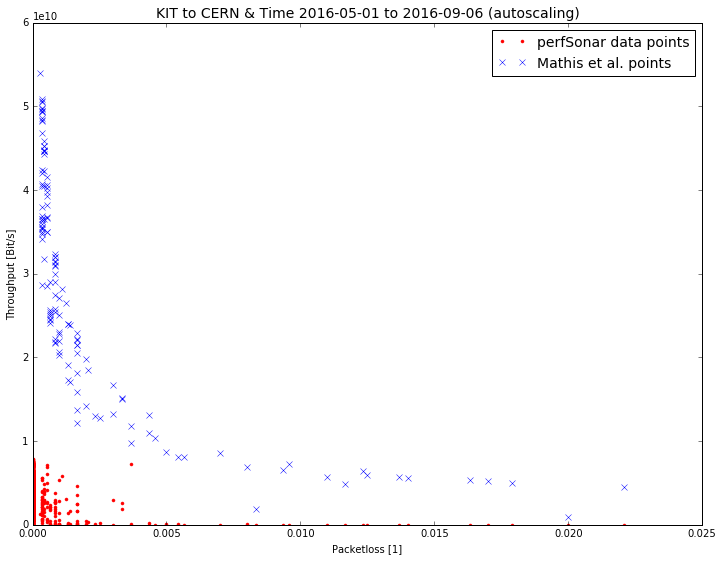

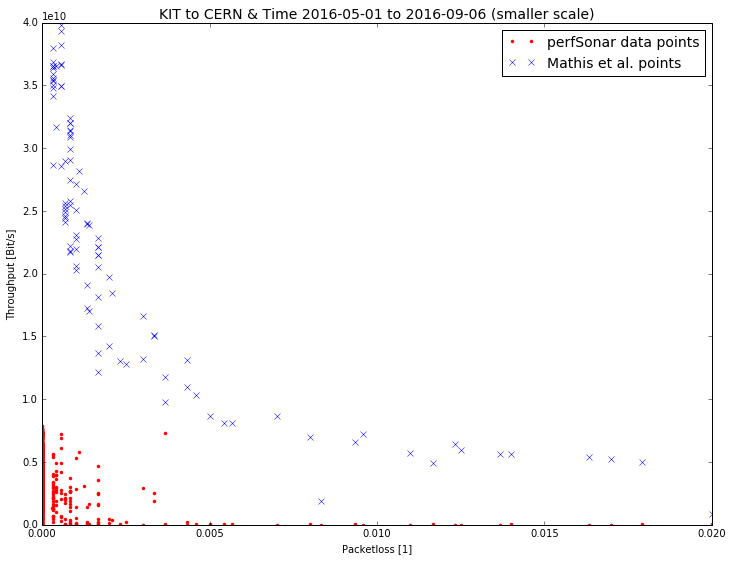

In [89]:
# do fancy string manupulation
plotTitle = rawDataPath_forth[rawDataPath_forth.find('from_')+5:rawDataPath_forth.find('_sorted')].replace('_', ' ').replace('and t', '& T')
plotTitle += ' (autoscaling)'

dataSetsWithPacketloss = getDataSetWithPacketloss(dataSet)

# sort for packetloss
# when sorted mathis formular dosen't work anymore...
#dataSetsWithPacketloss.sort_values('packet_loss', ascending=1, inplace=True)

RTT_Array = np.empty(len(dataSetsWithPacketloss))
for i in xrange(len(dataSetsWithPacketloss)):
    RTT_Array[i] = float(dataSetsWithPacketloss['delay_current_average_forth'][i] + dataSetsWithPacketloss['delay_current_average_back'][i])


MSS = 8860

# plot the data we got
plt.figure(figsize=(12,9), dpi=400)
plt.title(plotTitle,fontsize=14)
plt.plot(dataSetsWithPacketloss['packet_loss'], dataSetsWithPacketloss['throughput'], 'r.', label=r'perfSonar data points')
# we need to take Mathis modell
plt.plot(dataSetsWithPacketloss['packet_loss'], calcMathisModel_outBitsPerSec(dataSetsWithPacketloss['packet_loss'], MSS, RTT_Array), 'bx', label=r'Mathis et al. points')
plt.legend(loc='best',fontsize=14)
plt.ylabel("Throughput [Bit/s]")
plt.xlabel("Packetloss [1]")
#plt.axis([0, 0.05, 0, 6*1e9])
# save plot
plt.savefig('plots/'+ plotTitle +'.png', format='PNG', dpi=300)
plt.show()

# change scale
plotTitle = plotTitle[0:len(plotTitle)-14] + ' (smaller scale)'
plt.figure(figsize=(12,9), dpi=400)
plt.title(plotTitle,fontsize=14)
plt.plot(dataSetsWithPacketloss['packet_loss'], dataSetsWithPacketloss['throughput'], 'r.', label=r'perfSonar data points')
# we need to take Mathis modell
plt.plot(dataSetsWithPacketloss['packet_loss'], calcMathisModel_outBitsPerSec(dataSetsWithPacketloss['packet_loss'], MSS, RTT_Array), 'bx', label=r'Mathis et al. points')
plt.legend(loc='best',fontsize=14)
plt.ylabel("Throughput [Bit/s]")
plt.xlabel("Packetloss [1]")
plt.axis([0, 0.02, 0, 40*1e9])
# save plot
plt.savefig('plots/'+ plotTitle +'.png', format='PNG', dpi=300)
plt.show()